In [44]:
from scipy.optimize import minimize, brute
from blender_tissue_cartography import rotation as tcrot
from blender_tissue_cartography import registration as tcreg
from blender_tissue_cartography import harmonic as tcharm
from spherical_analysis import * 
from skimage import io, exposure, transform
import json
import os

This example will demonstrate how to register multiple embryos into a common reference frame.

In [3]:
# paremters
json_dir = r"/mnt/data1/Code/GH_local/spherical_harmonic_rotation/dataset_8/"
json_name = r"dataset_8.json"

# reads in json 
with open(os.path.join(json_dir, json_name), 'r') as f:
    dataset = json.load(f)

# sort by time if not already
dataset = dict(sorted(dataset.items(), key=lambda x: int(x[0][4:])))

# convert back necessary values back to nd_array
for d in dataset.values():
    d['center'] = np.array(d['center'])

Suppose we want to register the pullbacks to this photo of a very circular arrow, so we have the fish's body right side up:

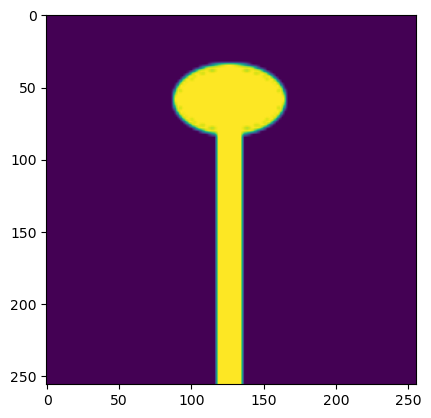

In [45]:
# load in a registration template
template = transform.resize(io.imread("Circular-Arrow.tif"), (256, 256))
plt.imshow(template)

In [40]:
uv_grid_steps = 256

# integration grid
phi_grid, theta_grid = np.meshgrid(np.arange(uv_grid_steps), np.arange(uv_grid_steps))
phi_grid = 2*np.pi*phi_grid/uv_grid_steps
theta_grid = np.pi*theta_grid/uv_grid_steps

# create measure
dTheta, dPhi = (np.pi/uv_grid_steps, 2*np.pi/uv_grid_steps)
weights = np.sin(theta_grid)*dTheta*dPhi # spherical integration measure

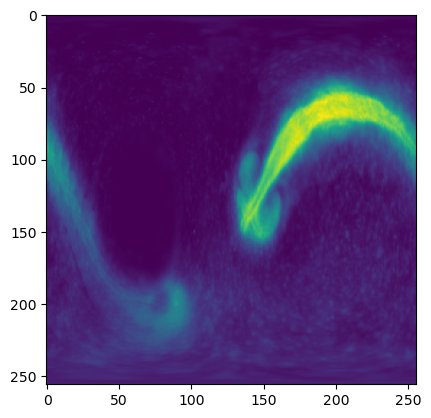

In [ ]:
# select time point with well defined features
d = dataset['time95']

# read in image 
im = clip_pad_image(io.imread(d['path']), d['alpha'], d['padding'])

# create pullback
im_vol = create_interpolated_volume(im)
f = np.sum(spherical_pullback(im_vol, d['center'], d['radius'], thickness=64, theta_res=256, phi_res=256), axis=0)

# view 
plt.imshow(f)

In [46]:
# compute coefficients
coeffs_im = tcrot.compute_spherical_harmonics_coeffs(f, phi_grid, theta_grid, weights=weights, max_l=8)
coeffs_template = tcrot.compute_spherical_harmonics_coeffs(template, phi_grid, theta_grid, weights=weights, max_l=8)

# get rotation
rotation_inferred, overlap = tcrot.rotational_alignment(coeffs_im, coeffs_template, allow_flip=False, n_subdiv_axes=2, n_angle=200, maxfev=500)

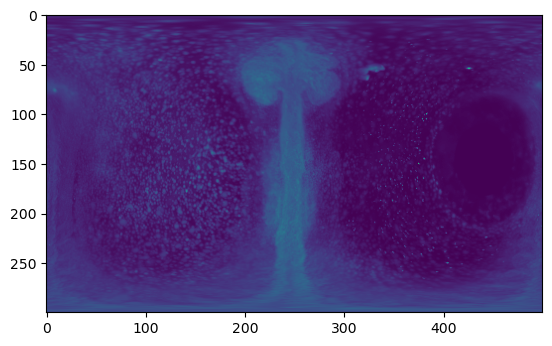

In [48]:
# create the pullback in with the rotation
im_vol_rotated = create_rotated_volume(im_vol, rotation_inferred.T, d['center']) 

# change the resolution, use a max projection instead of sum projection for aesthetics
f_rot = np.max(spherical_pullback(im_vol_rotated, d['center'], d['radius'], thickness=64, theta_res=300, phi_res=500), axis=0)

plt.imshow(f_rot)

Let's do this with another dataset. This time registering the new dataset to the rotated version of the previous dataset.

In [22]:
# paremters
json_dir = r"/mnt/data1/Code/GH_local/spherical_harmonic_rotation/dataset_5/"
json_name = r"dataset_5.json"

# reads in json 
with open(os.path.join(json_dir, json_name), 'r') as f:
    dataset2 = json.load(f)

# sort by time if not already
dataset2 = dict(sorted(dataset2.items(), key=lambda x: int(x[0][4:])))

# convert back necessary values back to nd_array
for d in dataset2.values():
    d['center'] = np.array(d['center'])

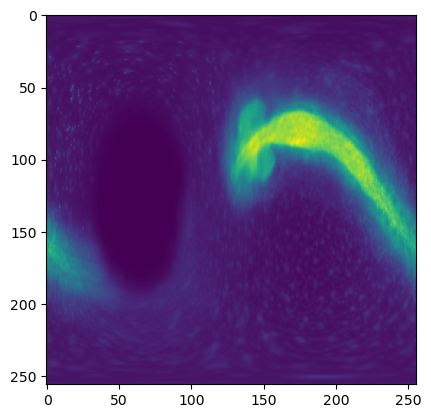

In [49]:
# select time with well defined features
d2 = dataset2['time90']

# read in image 
im2 = clip_pad_image(io.imread(d2['path']), d2['alpha'], d2['padding'])

# create pullback
im2_vol = create_interpolated_volume(im2)
g = np.sum(spherical_pullback(im2_vol, d2['center'], d2['radius'], thickness=64, theta_res=256, phi_res=256), axis=0)

# view 
plt.imshow(g)

In [ ]:
# first make a pullback with the same dimensions as integration grid (256x256)
f_rot_lower_res =  np.sum(spherical_pullback(im_vol_rotated, d['center'], d['radius'], thickness=64, theta_res=256, phi_res=256), axis=0)

# compute coefficients between the the previous rotated image and this one
coeffs_im2 = tcrot.compute_spherical_harmonics_coeffs(g, phi_grid, theta_grid, weights=weights, max_l=8)
coeffs_im_rotated = tcrot.compute_spherical_harmonics_coeffs(f_rot_lower_res, phi_grid, theta_grid, weights=weights, max_l=8)

# get rotation
rotation_inferred, overlap = tcrot.rotational_alignment(coeffs_im2, coeffs_im_rotated, allow_flip=False, n_subdiv_axes=2, n_angle=200, maxfev=500)

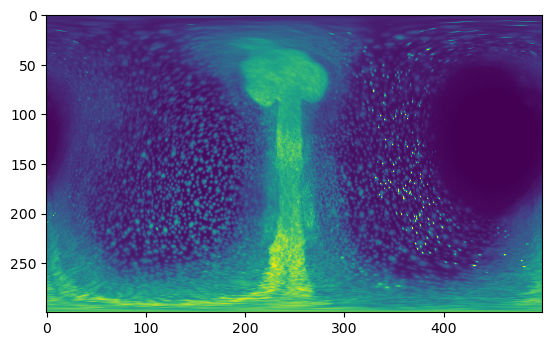

In [58]:
# create the pullback in with the rotation
im2_vol_rotated = create_rotated_volume(im2_vol, rotation_inferred.T, d2['center']) 

# change the resolution, use a max projection instead of sum projection for aesthetics
g_rot = np.max(spherical_pullback(im2_vol_rotated, d2['center'], d2['radius'], thickness=64, theta_res=300, phi_res=500), axis=0)

plt.imshow(g_rot, vmax=100)

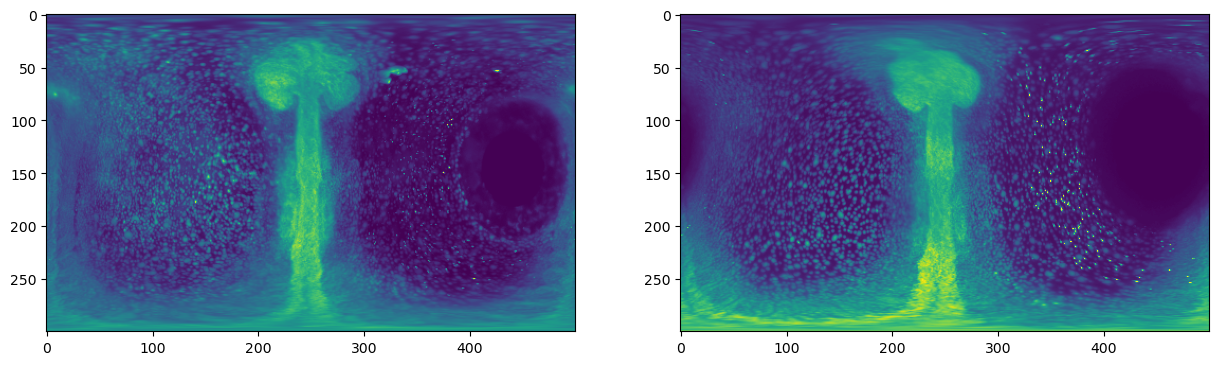

In [57]:
# plot both side by side
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 12))
ax1.imshow(f_rot, vmax=100)
ax2.imshow(g_rot, vmax=100)